In [1]:
import sys
import os
import numpy as np
from scipy.optimize import curve_fit
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import pdb #python debugger
from timeit import default_timer as timer #timer
from collections import OrderedDict
import importlib
sys.path.insert(1,'/home/ryanlopez/ABPTutorial/c++') #Connects to ABP Folder github.com/ryanlopezzzz/ABPTutorial
from cppmd.builder import *
import cppmd as md
import read_data as rd #reads snapshot text data
import directories #used to create directories for saving data
import Physical_Quantities.vorticity as vorticity
import Physical_Quantities.flocking_factors as flocking_factors
import Physical_Quantities.fourier_calculations as fc
import Physical_Quantities.various as various
importlib.reload(vorticity)
importlib.reload(fc)

<module 'Physical_Quantities.fourier_calculations' from '/home/ryanlopez/codes/Physical_Quantities/fourier_calculations.py'>

In [5]:
def save_fig_pdf(base_filename, extra_label):
    save_filename = os.path.join(base_filename, extra_label)
    plt.savefig(save_filename, format='pdf', bbox_inches='tight')

In [4]:
def edges_from_centers_linear(centers):
    """
    Returns bin edges for histogram given array of centers spaced linearly
    
    Input centers: [a, a+1*b, a+2*b, ..., a+ (n-1)*b] (linearly spaced centers)
    Output edges: [a-b/2, a+b/2, a+3b/2, ..., a+(n-1/2)*b] (linearly spaced bin edges which surround centers)
    """
    a = centers[0]
    b = centers[1]-centers[0]
    n = len(centers)
    
    edges_first_value = a-b/2
    edges_last_value = a+(n-1/2)*b
    edges_length = n+1
    
    edges = np.linspace(edges_first_value, edges_last_value, edges_length)
    return edges

def edges_from_centers_log(centers):
    """
    Returns bine edges for histogram given array of center spaced linearly
    """
    centers_log = np.log(centers)
    edges_log = edges_from_centers_linear(centers_log)
    edges = np.exp(edges_log)
    
    return edges

In [4]:
Dr_vals = np.logspace(-4,-1,num=7)
Jv_vals = np.logspace(-2,1,num=7)

phi=1
v0 = 0.001

print(Dr_vals)
print(Jv_vals)

Dr_bins = edges_from_centers_log(Dr_vals)
Jv_bins = edges_from_centers_log(Jv_vals)

[0.0001     0.00031623 0.001      0.00316228 0.01       0.03162278
 0.1       ]
[ 0.01        0.03162278  0.1         0.31622777  1.          3.16227766
 10.        ]


In [5]:
vicsek_values = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float) #fill with 100 so can see if an index not replaced
dir_dot_vel_values = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)
dir_dot_vel_norm_values = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float) 
dir_cross_vel_values = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)
dir_cross_vel_norm_values = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float) 
vel_mag_var_values = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float) 
r_local_align = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)

vicsek_dev = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)
dir_dot_vel_dev = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)
dir_dot_vel_norm_dev = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float) 
dir_cross_vel_dev = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)
dir_cross_vel_norm_dev = np.full([len(Dr_vals), len(Jv_vals)], 100, dtype = float)

#These are empty list of lists of same size as above np arrays
msd_values = [[[] for _ in range(len(Jv_vals))] for __ in range(len(Dr_vals))]
msd_minus_flock_values = [[[] for _ in range(len(Jv_vals))] for __ in range(len(Dr_vals))]
msd_parallel_values = [[[] for _ in range(len(Jv_vals))] for __ in range(len(Dr_vals))]
msd_perp_values = [[[] for _ in range(len(Jv_vals))] for __ in range(len(Dr_vals))]

In [6]:
#Directory where all data is saved
save_dir = "/home/ryanlopez/Velocity_Align_Saved_Data"
exp_folder_name = "phi=%.2f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
image_dir = os.path.join(exp_dir, 'images')
if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

for f in os.scandir(exp_dir): #runs through all immediate subdirectories
    if os.path.isdir(os.path.join(f, "snapshot_data/")):
        run_desc_file = open(os.path.join(f, 'run_desc.json'))
        run_desc = json.loads(run_desc_file.read())
        run_desc_file.close()
        
        single_stats_file = open(os.path.join(f, 'single_stats.json'))
        single_stats = json.loads(single_stats_file.read())
        single_stats_file.close()
        
        Jv_index = np.digitize(run_desc['J']*v0, Jv_bins)-1
        Dr_index = np.digitize(run_desc['D_r'], Dr_bins)-1
        
        vicsek_values[Dr_index, Jv_index] = single_stats['vicsek_param']
        dir_dot_vel_values[Dr_index, Jv_index] = single_stats['dir_dot_vel']
        dir_dot_vel_norm_values[Dr_index, Jv_index] = single_stats['dir_dot_vel_norm']
        dir_cross_vel_values[Dr_index, Jv_index] = single_stats['dir_cross_vel']
        dir_cross_vel_norm_values[Dr_index, Jv_index] = single_stats['dir_cross_vel_norm']
        vel_mag_var_values[Dr_index, Jv_index] = single_stats['vel_mag_rel_var']
        r_local_align[Dr_index, Jv_index] = single_stats['R_avg']
        
        vicsek_dev[Dr_index, Jv_index] = single_stats['vicsek_param_std_dev']
        dir_dot_vel_dev[Dr_index, Jv_index] = single_stats['dir_dot_vel_std_dev']
        dir_dot_vel_norm_dev[Dr_index, Jv_index] = single_stats['dir_dot_vel_norm_std_dev']
        dir_cross_vel_dev[Dr_index, Jv_index] = single_stats['dir_cross_vel_std_dev']
        dir_cross_vel_norm_dev[Dr_index, Jv_index] = single_stats['dir_cross_vel_norm_std_dev']
                      
        msd = np.load(os.path.join(f, 'msd.npy'))
        msd_minus_flock = np.load(os.path.join(f, 'msd_minus_flock.npy'))
        msd_parallel = np.load(os.path.join(f, 'msd_parallel.npy'))
        msd_perp = np.load(os.path.join(f, 'msd_perp.npy'))
        
        msd_values[Dr_index][Jv_index] = msd
        msd_minus_flock_values[Dr_index][Jv_index] = msd_minus_flock   
        msd_parallel_values[Dr_index][Jv_index] = msd_parallel
        msd_perp_values[Dr_index][Jv_index] = msd_perp

In [7]:
msd_values = np.array(msd_values)
msd_minus_flock_values = np.array(msd_minus_flock_values)
msd_parallel_values = np.array(msd_parallel_values)
msd_perp_values = np.array(msd_perp_values)

In [8]:
simulation_desc = r"$\phi=%.2f$, $v_0=%.1e$, k=1, L=70, Simulation Time = $2 \times 10^{3}$"%(phi, v0)
#r"$D_r=0.1, v_0=1$, k=1, L=70, Simulation Time = $2 \times 10^{3}$"
#r"$T_{eff}=10^{-3}, \phi= 1$, k=1, L=70, Simulation Time = $2 \times 10^{3}$"

plt_xlabel = r'$Jv_0$'
plt_ylabel = r'$D_r$'

In [ ]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,vicsek_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("R Local Align Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"R is radius of local aligned region", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'r_local_align_phase_diagram.pdf')
plt.show()

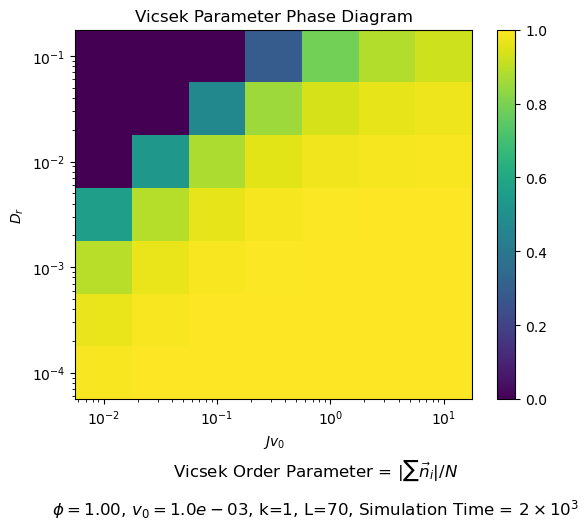

In [9]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,vicsek_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Vicsek Parameter Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'vicsek_phase_diagram.pdf')
plt.show()

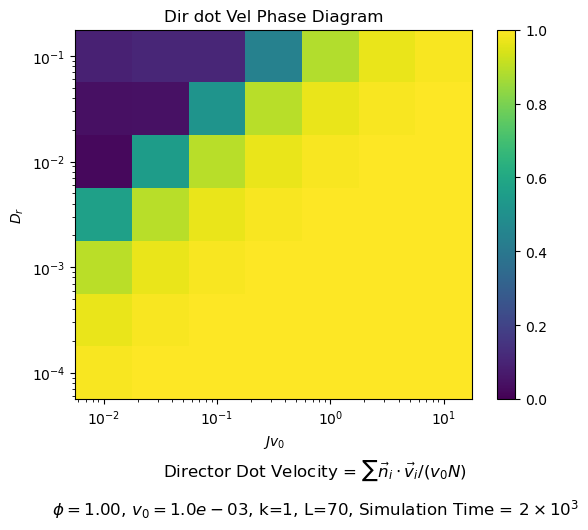

In [10]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_dot_vel_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Dir dot Vel Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"Director Dot Velocity = $\sum \vec{n}_i \cdot \vec{v}_i / (v_0 N)$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_phase_diagram.pdf')
plt.show()

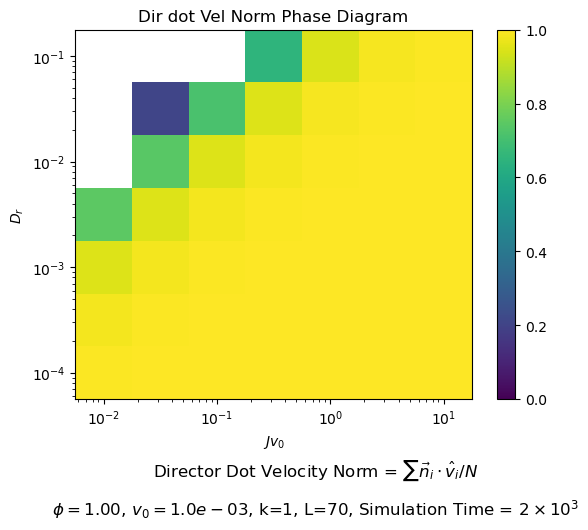

In [11]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_dot_vel_norm_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Dir dot Vel Norm Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"Director Dot Velocity Norm = $\sum \vec{n}_i \cdot \hat{v}_i / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_norm_phase_diagram.pdf')
plt.show()

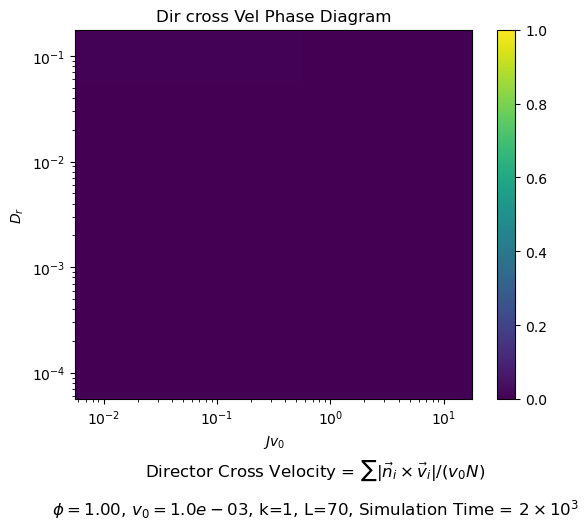

In [12]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_cross_vel_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Dir cross Vel Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"Director Cross Velocity = $\sum \left|\vec{n}_i \times \vec{v}_i \right| / (v_0 N)$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_cross_vel_phase_diagram.pdf')
plt.show()

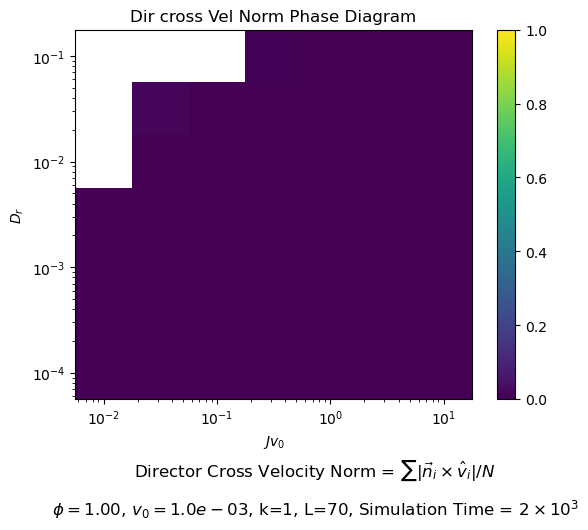

In [14]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_cross_vel_norm_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Dir cross Vel Norm Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"Director Cross Velocity Norm = $\sum \left|\vec{n}_i \times \hat{v}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_cross_vel_norm_phase_diagram.pdf')
plt.show()

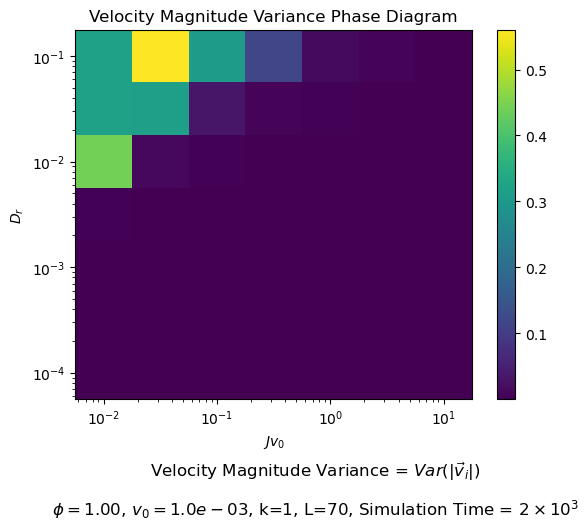

In [15]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(Jv_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges, vel_mag_var_values)
plt.colorbar(plot)
plt.title("Velocity Magnitude Variance Phase Diagram")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

plt.xscale('log')
plt.yscale('log')

fig.text(.5, -0.05, r"Velocity Magnitude Variance = $Var(|\vec{v}_i|)$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'vel_mag_var_phase_diagram.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots()
for i in range(vicsek_values.shape[0]):
    ax.errorbar(J_vals, vicsek_values[i],yerr=vicsek_dev[i],capsize=5,ms=5,label=r'$\phi$=%.2f'%Dr_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various Packing Fraction ($\phi$) Lines')
plt.xlabel('J')
plt.ylabel('Vicsek Order Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
save_fig_pdf(image_dir, 'vicsek_packing_frac_lines.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots()
for i in range(vicsek_values.shape[1]):
    if i%2 == 0:
        ax.errorbar(Dr_vals, vicsek_values[:,i],yerr=vicsek_dev[:,i],capsize=5,ms=5,label=r'$J$=%.2f'%J_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $J$ Lines')
plt.xlabel(r'Packing Fraction')
plt.ylabel('Vicsek Order Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'vicsek_J_lines.pdf')

In [ ]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_values.shape[0]):
    ax.errorbar(J_vals, dir_dot_vel_values[i],yerr=dir_dot_vel_dev[i],capsize=5,ms=5,label=r'$\phi$=%.2f'%Dr_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various Packing Fraction $(\phi)$ Lines')
plt.xlabel('J')
plt.ylabel('Dir dot Vel Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity = $\sum \vec{n}_i \cdot \vec{v}_i / (v_0 N)$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_packing_frac_lines.pdf')

In [ ]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_values.shape[1]):
    if i%2 == 0:
        ax.errorbar(Dr_vals, dir_dot_vel_values[:,i],yerr=dir_dot_vel_dev[:,i],capsize=5,ms=5,label=r'$J$=%.2f'%J_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $J$ Lines')
plt.xlabel(r'Packing Fraction')
plt.ylabel('Dir dot Vel Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity = $\sum \vec{n}_i \cdot \vec{v}_i / (v_0 N)$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_J_lines.pdf')

In [ ]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_norm_values.shape[0]):
    ax.errorbar(J_vals, dir_dot_vel_norm_values[i],yerr=dir_dot_vel_norm_dev[i],capsize=5,ms=5,label=r'$\phi$=%.2f'%Dr_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various Packing Fraction $(\phi)$ Lines')
plt.xlabel('J')
plt.ylabel('Dir dot Vel Norm Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity Norm = $\sum \vec{n}_i \cdot \hat{v}_i / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_norm_packing_frac_lines.pdf')

In [ ]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_norm_values.shape[1]):
    if i%2 == 0:
        ax.errorbar(Dr_vals, dir_dot_vel_norm_values[:,i],yerr=dir_dot_vel_norm_dev[:,i],capsize=5,ms=5,label=r'$J$=%.2f'%J_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $J$ Lines')
plt.xlabel(r'Packing Fraction')
plt.ylabel('Dir dot Vel Norm Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity Norm = $\sum \vec{n}_i \cdot \hat{v}_i / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_norm_J_lines.pdf')

In [ ]:
tf = run_desc['tf']
num_snapshots = len(msd_values[0][0])
times = np.linspace(0,tf,num_snapshots+1)[1:]
A = 0.1 / (times[0]) #coefficient for plotting slope 1 and 2 lines log-log

msd_dir = os.path.join(image_dir, 'msd_images')
if not os.path.isdir(msd_dir):
    os.mkdir(msd_dir)   

In [ ]:
for Dr_index in range(len(Dr_vals)):
    fig, ax = plt.subplots()
    colors=plt.cm.nipy_spectral(np.linspace(0,1,len(msd_values[Dr_index])+1))
    for i in range(len(msd_values[Dr_index])):
        #if i%2 ==0:
        ax.loglog(times, msd_values[Dr_index][i], color=colors[i+1],label=r'$J$=%.2f'%(J_vals[i]))  
    ax.plot((times), (A*times),color='black',linestyle='--',label=r'slope=1')
    ax.plot((times), (A*times)**2,color='black',linestyle='--',label=r'slope=2')    
    
    plt.title(r'MSD for $D_r$=%.2f'%Dr_vals[Dr_index])
    plt.xlabel('Time (s)')
    plt.ylabel(r'MSD')
    plt.legend()
    fig.text(.5, -0.05, r"MSD = $<(\Delta x)^2 + (\Delta y)^2>$", ha='center', fontsize=12)
    fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
    save_fig_pdf(msd_dir, 'msd_Dr=%.2f_various_J_lines.pdf'%Dr_vals[Dr_index])

In [ ]:
for J_index in range(len(J_vals)):
    #if J_index %2 == 0:
    fig, ax = plt.subplots()
    colors=plt.cm.nipy_spectral(np.linspace(0,1,len(msd_values)+1))
    for i in range(len(msd_values)):
        ax.loglog(times, msd_values[i][J_index], color=colors[i+1],label=r'$D_r$=%.2f'%Dr_vals[i])
    ax.plot((times), (A*times),color='black',linestyle='--',label=r'slope=1')
    ax.plot((times), (A*times)**2,color='black',linestyle='--',label=r'slope=2')    

    plt.title(r'MSD for $J$=%.2f'%J_vals[J_index])
    plt.xlabel('Time (s)')
    plt.ylabel(r'MSD')
    plt.legend()
    fig.text(.5, -0.05, r"MSD = $<(\Delta x)^2 + (\Delta y)^2>$", ha='center', fontsize=12)
    fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
    save_fig_pdf(msd_dir, 'msd_J=%.2f_various_Dr_lines.pdf'%J_vals[J_index])

In [ ]:
for Dr_index in range(len(Dr_vals)):
    fig, ax = plt.subplots()
    colors=plt.cm.nipy_spectral(np.linspace(0,1,len(msd_values[Dr_index])+1))
    for i in range(len(msd_minus_flock_values[Dr_index])):
        #if i%2 ==0:
        ax.loglog(times, msd_minus_flock_values[Dr_index][i],color=colors[i+1],label=r'$J$=%.2f'%J_vals[i])
    ax.plot((times), (A*times),color='black',linestyle='--',label=r'slope=1')
    ax.plot((times), (A*times)**2,color='black',linestyle='--',label=r'slope=2')        

    plt.title(r'MSD Minus Flock for $D_r$=%.2f'%Dr_vals[Dr_index])
    plt.xlabel('Time (s)')
    plt.ylabel(r'MSD Minus Flock')
    plt.legend()
    fig.text(.5, -0.05, r"MSD Minus Flock= $<(\Delta x-<\Delta x>)^2 + (\Delta y - <\Delta y>)^2>$", ha='center', fontsize=12)
    fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
    save_fig_pdf(msd_dir, 'msd_minus_flock_Dr=%.2f_various_J_lines.pdf'%Dr_vals[Dr_index])

In [ ]:
for J_index in range(len(J_vals)):
    #if J_index % 2 == 0:
    fig, ax = plt.subplots()
    colors=plt.cm.nipy_spectral(np.linspace(0,1,len(msd_values)+1))
    for i in range(len(msd_minus_flock_values)):
        ax.loglog(times, msd_minus_flock_values[i][J_index],color=colors[i+1], label=r'$D_r$=%.2f'%Dr_vals[i])
    ax.plot((times), (A*times),color='black',linestyle='--',label=r'slope=1')
    ax.plot((times), (A*times)**2,color='black',linestyle='--',label=r'slope=2')            
    plt.title(r'MSD Minus Flock for $J$=%.2f'%J_vals[J_index])
    plt.xlabel('Time (s)')
    plt.ylabel(r'MSD Minus Flock')
    plt.legend()
    fig.text(.5, -0.05, r"MSD Minus Flock= $<(\Delta x-<\Delta x>)^2 + (\Delta y - <\Delta y>)^2>$", ha='center', fontsize=12)
    fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
    save_fig_pdf(msd_dir, 'msd_minus_flock_J=%.2f_various_Dr_lines.pdf'%J_vals[J_index])

In [ ]:
for Dr_index in range(len(Dr_vals)):
    fig, ax = plt.subplots()
    colors=plt.cm.nipy_spectral(np.linspace(0,1,len(msd_values[Dr_index])+2))
    for i in range(len(msd_values[Dr_index])):
        if i%2 ==0:
            ax.loglog(times, msd_perp_values[Dr_index][i], color=colors[i+1],label=r'$J$=%.2f, perp'%(J_vals[i])) 
            ax.loglog(times, msd_parallel_values[Dr_index][i], linestyle=":",color=colors[i+1],label=r'$J$=%.2f, paral'%(J_vals[i]))  
    ax.plot((times), (A*times),color='black',linestyle='--',label=r'slope=1')
    ax.plot((times), (A*times)**2,color='black',linestyle='--',label=r'slope=2')    
    
    plt.title(r'MSD Parallel for $D_r$=%.2f'%Dr_vals[Dr_index])
    plt.xlabel('Time (s)')
    plt.ylabel(r'MSD')
    plt.legend()
    fig.text(.5, -0.05, r"MSD = $<(\Delta x)^2 + (\Delta y)^2>$", ha='center', fontsize=12)
    fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
    save_fig_pdf(msd_dir, 'msd_pvp_Dr=%.2f_various_J_lines.pdf'%Dr_vals[Dr_index])

In [ ]:
for J_index in range(len(J_vals)):
    if J_index %2 == 0:
        fig, ax = plt.subplots()
        colors=plt.cm.nipy_spectral(np.linspace(0,1,len(msd_values)+1))
        for i in range(len(msd_values)):
            ax.loglog(times, msd_perp_values[i][J_index], color=colors[i+1],label=r'$D_r$=%.2f'%Dr_vals[i])
            ax.loglog(times, msd_parallel_values[i][J_index], linestyle=":",color=colors[i+1],label=r'$D_r$=%.2f'%Dr_vals[i])

        ax.plot((times), (A*times),color='black',linestyle='--',label=r'slope=1')
        ax.plot((times), (A*times)**2,color='black',linestyle='--',label=r'slope=2')    

        plt.title(r'MSD for $J$=%.2f'%J_vals[J_index])
        plt.xlabel('Time (s)')
        plt.ylabel(r'MSD')
        plt.legend()
        fig.text(.5, -0.05, r"MSD = $<(\Delta x)^2 + (\Delta y)^2>$", ha='center', fontsize=12)
        fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
        save_fig_pdf(msd_dir, 'msd_pvp_J=%.2f_various_Dr_lines.pdf'%J_vals[J_index])

In [ ]:
###### Calculate power law regression

"""
Function for power regression
"""
import scipy.optimize as optimize
def f(x,a,b):
    return a*x + b
def get_power_factor(xdata, ydata):
    popt, pcov = optimize.curve_fit(f, np.log(xdata), np.log(ydata))
    power_factor = popt[0]
    #power_factor = np.around(power_factor) #round to nearest int
    return power_factor

power_factors = np.zeros_like(msd_values[...,-1])
power_no_flock_factors = np.zeros_like(msd_values[...,-1])

for index, value in np.ndenumerate(power_factors):
    power_factors[index] = get_power_factor(times, msd_values[index])
    power_no_flock_factors[index] = get_power_factor(times, msd_minus_flock_values[index])

In [ ]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,power_factors,vmin=0,vmax=2)#,norm=colors.LogNorm(vmin=1)) #, vmin=-1, vmax=1)

plt.colorbar(plot)
plt.title(r"MSD power factor $p$")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

fig.text(.5, -0.05, r"MSD $\approx \alpha t^p$ regression, forced between 0 and 2.", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)

save_fig_pdf(msd_dir, 'msd_power_phase_diagram.pdf')

In [ ]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,power_no_flock_factors,vmin=0,vmax=2)#,norm=colors.LogNorm(vmin=1))#, vmin=0, vmax=100)

plt.colorbar(plot)
plt.title(r"MSD Minus Flock power factor $p$")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel)

fig.text(.5, -0.05, r"MSD minus flock $\approx \alpha t^p$ regression, forced between 0 and 2.", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
save_fig_pdf(msd_dir, 'msd_minus_flock_power_phase_diagram.pdf')